In [1]:
#This example jup notebook corresponds to the analysis of data presented in Figure 6 and Extended Data Fig 10 of Altemose et. al. 2022 Nature Methods paper.
#Used for analyzing 1x601 Chromatin DiMeLo-seq and sensitivity measurements
#This particular example is for the CDR of ChrX centromere - ChrX 57.45 Mb to 57.75 Mb
#Input - *_probs.csv file generated by DiMeLoseq_in_situ_roi_single_molecule_v7_q10.py
#Input - csv contains arrays with each row representing reads with every base position within the roi and values between 0 - 255 indicate methylation probability score from guppy all context basecalling
#Input - *_pos.csv contains arrays with each row representing reads with every base position within the roi and value (0,1) indicating A (or T position for reverse reads) from guppy all context basecalling

In [2]:
#<outdir> output directory
outfolder = '<outdir>'

In [3]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
#from scipy.stats import kde
%matplotlib inline
from matplotlib import colors

import math

from scipy import sparse


In [4]:
## Enter the correct bed start, bed end and windowsize (same as in the *V5.py file) info below

In [5]:
Chromosome_Region = 'ChrX_CDR_300kb_5745_5775_v7'

In [6]:
bedstart = 57450000
bedend = 57750000
windowsize = 150000
windowstart = (bedstart+bedend)/2-windowsize
windowend = (bedstart+bedend)/2+windowsize

In [7]:
Barcode_name = {17:'free', 18:'CA', 19:'IgG', 20:'unt'}
#mod = ['A','C'] # if you want to iterate over mA and mC as well
mod = ['A'] # if you want to just iterate over mA
#Barcode_name = {18:'CA'}

In [8]:
mod_csv = {i:{} for i in Barcode_name.keys()}
read_prob = {i:{} for i in Barcode_name.keys()}


In [10]:
for i in [17,18,19,20]:
    #Example file name:
    filename_prob = '<filepath>/' + str(Barcode_name[i]) + '_' + str('A') + '_prob.csv'
    read_prob[i]['A'] = np.genfromtxt(filename_prob, dtype = float, delimiter = ',')[1:,1:]


In [12]:
read_pos = {i:{} for i in Barcode_name.keys()}


In [13]:
for i in [17,18,19,20]:
    read_pos[i]['A'] = np.empty(np.shape(read_prob[i]['A']))
    read_pos[i]['A'][:] = np.NaN
    read_pos[i]['A'][(read_prob[i]['A'])>=0] = 1

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater_equal
  after removing the cwd from sys.path.


In [15]:
read_start = {i:{} for i in Barcode_name.keys()}
read_end = {i:{} for i in Barcode_name.keys()}
for j in ['A']:
    for i in Barcode_name.keys():
        read_start[i][j] = np.asarray([np.nonzero(read)[0][0] for read in np.nan_to_num(read_pos[i][j])])
        read_end[i][j] = np.asarray([np.nonzero(read)[0][-1] for read in np.nan_to_num(read_pos[i][j])])
    

In [16]:
read_coverage = {i:{} for i in Barcode_name.keys()}
total_coverage = {i:{} for i in Barcode_name.keys()}
for j in ['A']:
    for i in Barcode_name.keys():
        windowlen = np.shape(read_pos[i][j])[1]
        read_coverage[i][j] = []
        for k in range(0,np.shape(read_pos[i][j])[0]):
            read_coverage[i][j].append(np.zeros(windowlen))
            read_coverage[i][j][k][read_start[i][j][k]:read_end[i][j][k]+1] = 1
        total_coverage[i][j] = np.nansum(read_coverage[i][j], axis=0)

In [18]:
window = (int(windowstart), int(windowend))

In [19]:
thr = 0.6*255
win = 250

In [20]:
read_mod = {i:{} for i in Barcode_name.keys()}
binned_average_read_mod_thr_1kb= {i:{} for i in Barcode_name.keys()}
for j in mod:
    for i in Barcode_name.keys():
        print(Barcode_name[i], j)
        read_mod[i][j] = np.empty(np.shape(read_prob[i][j]))
        read_mod[i][j][:] = np.NaN
        read_mod[i][j][read_prob[i][j] > thr] = 1
        binned_average_read_mod_thr_1kb[i][j] = pd.DataFrame.to_numpy(pd.DataFrame(np.nan_to_num(np.nanmean(read_mod[i][j], axis = 0))).rolling(window = win).mean())

free A


/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':


CA A
IgG A
unt A


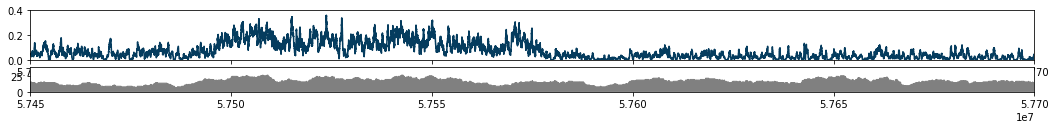

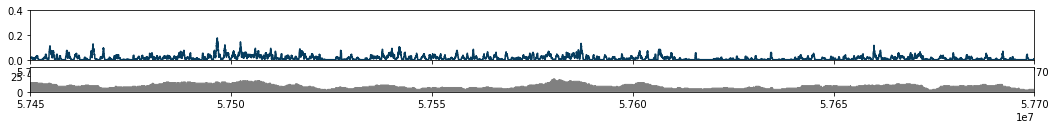

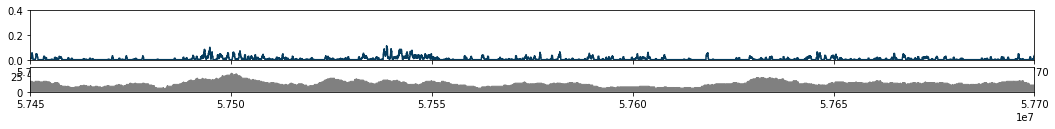

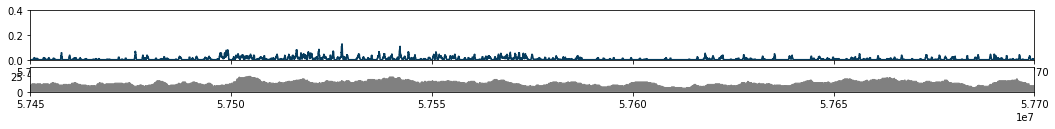

In [21]:
x = np.arange(windowstart,windowend+1)

for j in ['A']:
    if j == 'A':
        colorpal = '#053C5E'
    elif j =='C':
        colorpal = '#BB4430'
    for i in [18,17,19,20]:
        a = 0
        fig,ax = plt.subplots(2,1, figsize = (18,1.5), gridspec_kw={'height_ratios': [2, 1]})
        ax[a].plot(x,binned_average_read_mod_thr_1kb[i][j],colorpal)
        #ax[a].set_title(Barcode_name[i] + ' m6A', loc='left', pad=1, fontsize = 12)
        #if j == 'A': 
        ax[a].set_ylim(0,0.4)
        #elif j == 'C':
         #   ax[a].set_ylim(0,0.03)
        ax[a].set_xlim(window[0],window[1]-50000)
        a += 1
        #ax[a].plot(x,total_coverage[i][j], 'grey')
        ax[a].fill_between(x,total_coverage[i]['A'], color = 'grey')
        #ax[a].set_title(Barcode_name[i] + ' coverage', loc='left', pad=1, fontsize = 12)
        #ax[a].axhline(5, color = 'r', linestyle = '--', alpha=0.5, linewidth = 1)
        ax[a].set_ylim(0,40)
        ax[a].set_xlim(window[0],window[1]-50000)
        fig.savefig(outfolder + Chromosome_Region +str(win) + '_bp' + '_thr' + str(thr) + Barcode_name[i] + '_' + 'A' + '_' + str(window[0]) + '_' + str(window[1]) + '.png', dpi=300, bbox_inches='tight')
        plt.show()

In [22]:
#Enter bin size here if binning each read
bin_size = 1

In [23]:
#NaN sensitive binning of all A probability scores
read_prob_bin_nanmean = {i:{} for i in Barcode_name.keys()}
for i in [17,18,19,20]:
    read_prob_cumsum = np.pad(np.nancumsum(read_prob[i][j], axis = 1), ((0,0),(bin_size,bin_size)), constant_values = np.NaN)
    read_pos_cumsum = np.pad(np.nancumsum(read_pos[i][j], axis = 1), ((0,0),(bin_size,bin_size)), constant_values = np.NaN)

    read_prob_binsum = read_prob_cumsum[:,bin_size:np.shape(read_prob[i][j])[1]+bin_size] - read_prob_cumsum[:,0:np.shape(read_prob[i][j])[1]]

    read_pos_binsum = read_pos_cumsum[:,bin_size:np.shape(read_prob[i][j])[1]+bin_size] - read_pos_cumsum[:,0:np.shape(read_prob[i][j])[1]]

    read_prob_bin_nanmean[i] = read_prob_binsum/read_pos_binsum

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


In [24]:
#Determining bins with > threshold (0.6) methylation
nuc_call_prob = {i:{} for i in Barcode_name.keys()}
for i in [17,18,19,20]:
    nuc_call_prob[i] = pd.DataFrame.to_numpy(pd.DataFrame(read_prob_bin_nanmean[i] > (0.6*255)).rolling(window = 200, axis = 1).sum())


/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


In [103]:
#Determining % of reads within each 5kb bin with > 2.5 bins methylated
nuc_call_prob_5k = {i:{} for i in Barcode_name.keys()}
for i in [17,18,19,20]:
    nuc_call_prob_5k[i] = pd.DataFrame.to_numpy(pd.DataFrame((nuc_call_prob[i] > 2.5)*(nuc_call_prob[i] <=30)).rolling(window = 5000, axis = 1).sum())/5000


/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until
/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less_equal
  This is separate from the ipykernel package so we can avoid doing imports until


In [29]:
np.arange(0,40,5)

array([ 0,  5, 10, 15, 20, 25, 30, 35])

In [68]:
nuc_call_prob_5k_iter = {i:{} for i in Barcode_name.keys()}
mean_CDR_iter = {i:[] for i in Barcode_name.keys()}
mean_nonCDR_iter = {i:[] for i in Barcode_name.keys()}
for i in [17,18,19,20]:
    for cutoff in np.arange(1,21):
        nuc_call_prob_5k_iter[i] = pd.DataFrame.to_numpy(pd.DataFrame((nuc_call_prob[i] >= cutoff+1)*(nuc_call_prob[i] < 40)).rolling(window = 5000, axis = 1).sum())/5000
        mean_CDR_iter[i].append(np.round(np.mean((np.sum(nuc_call_prob_5k_iter[i], axis = 0)/total_coverage[i][j])[50000:125000]),2))
        mean_nonCDR_iter[i].append(np.round(np.mean((np.sum(nuc_call_prob_5k_iter[i], axis = 0)/total_coverage[i][j])[150000:225000]),2))
    plt.plot(np.arange(1,21),mean_CDR_iter[i], label = Barcode_name[i] + ' CDR')
    plt.plot(np.arange(1,21),mean_nonCDR_iter[i], label = Barcode_name[i] + ' nonCDR')

    plt.legend()
plt.show()

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater_equal
  
/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less
  


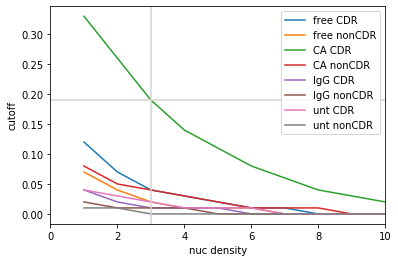

In [92]:
for i in [17,18,19,20]:
    plt.plot(np.arange(1,21),mean_CDR_iter[i], label = Barcode_name[i] + ' CDR')
    plt.plot(np.arange(1,21),mean_nonCDR_iter[i], label = Barcode_name[i] + ' nonCDR')
    plt.legend()
    plt.xlim(0,10)
plt.xlabel('nuc density')
plt.ylabel('cutoff')
plt.axvline(3,0,1, color = 'lightgrey')
plt.axhline(0.19,0,1, color = 'lightgrey')
plt.show()

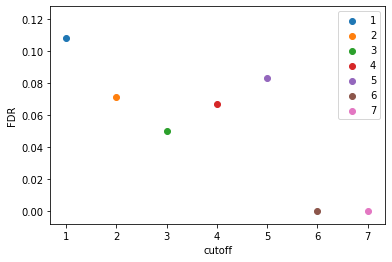

In [104]:
for cutoff in np.arange(1,8):
         plt.scatter(cutoff, mean_CDR_iter[19][cutoff-1]/(mean_CDR_iter[18][cutoff-1]+mean_CDR_iter[19][cutoff-1]), label = cutoff)
plt.legend()
plt.xlabel('cutoff')
plt.ylabel('FDR')

plt.show()


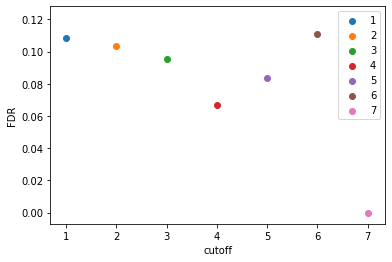

In [114]:
for cutoff in np.arange(1,8):
         plt.scatter(cutoff, mean_CDR_iter[20][cutoff-1]/(mean_CDR_iter[18][cutoff-1]+mean_CDR_iter[20][cutoff-1]), label = cutoff)
plt.legend()
plt.xlabel('cutoff')
plt.ylabel('FDR')
plt.show()


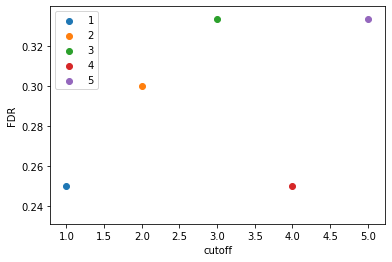

In [113]:
for cutoff in np.arange(1,6):
         plt.scatter(cutoff, mean_CDR_iter[20][cutoff-1]/(mean_CDR_iter[17][cutoff-1]+mean_CDR_iter[20][cutoff-1]), label = cutoff)
plt.legend()
plt.xlabel('cutoff')
plt.ylabel('FDR')
plt.show()


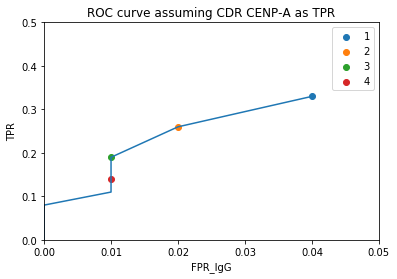

In [110]:
plt.plot(mean_CDR_iter[19],mean_CDR_iter[18])
plt.xlim(0,0.05)
plt.ylim(0,0.5)
for cutoff in np.arange(1,5):
    plt.scatter(mean_CDR_iter[19][cutoff-1],mean_CDR_iter[18][cutoff-1], label = cutoff)
plt.legend()
plt.xlabel('FPR_IgG')
plt.ylabel('TPR')
plt.title('ROC curve assuming CDR CENP-A as TPR')
plt.show()


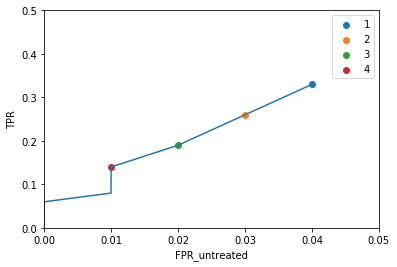

In [69]:
plt.plot(mean_CDR_iter[20],mean_CDR_iter[18])
plt.xlim(0,0.05)
plt.ylim(0,0.5)
for cutoff in np.arange(1,5):
    plt.scatter(mean_CDR_iter[20][cutoff-1],mean_CDR_iter[18][cutoff-1], label = cutoff)
plt.legend()
plt.xlabel('FPR_untreated')
plt.ylabel('TPR')
plt.show()


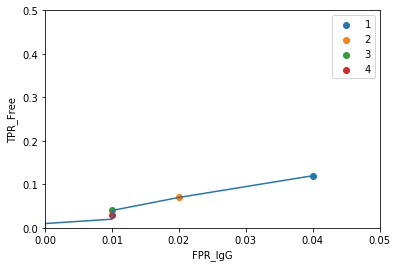

In [70]:
plt.plot(mean_CDR_iter[19],mean_CDR_iter[17])
plt.xlim(0,0.05)
plt.ylim(0,0.5)
for cutoff in np.arange(1,5):
    plt.scatter(mean_CDR_iter[19][cutoff-1],mean_CDR_iter[17][cutoff-1], label = cutoff)
plt.legend()
plt.xlabel('FPR_IgG')
plt.ylabel('TPR_Free')
plt.show()


In [105]:
i = 18
print('mean_CDR ','\t',np.round(np.mean((np.sum(nuc_call_prob_5k[i], axis = 0)/total_coverage[i][j])[50000:125000]),2))
print('stddev_CDR ','\t',np.round(np.std((np.sum(nuc_call_prob_5k[i], axis = 0)/total_coverage[i][j])[50000:125000]),2))
print('mean_nonCDR','\t', np.round(np.mean((np.sum(nuc_call_prob_5k[i], axis = 0)/total_coverage[i][j])[150000:225000]),2))
print('stddev_nonCDr ','\t',np.round(np.std((np.sum(nuc_call_prob_5k[i], axis = 0)/total_coverage[i][j])[150000:225000]),2))

mean_CDR  	 0.26
stddev_CDR  	 0.05
mean_nonCDR 	 0.05
stddev_nonCDr  	 0.02


In [106]:
i = 19
print('mean_CDR ','\t',np.round(np.mean((np.sum(nuc_call_prob_5k[i], axis = 0)/total_coverage[i][j])[50000:125000]),2))
print('stddev_CDR ','\t',np.round(np.std((np.sum(nuc_call_prob_5k[i], axis = 0)/total_coverage[i][j])[50000:125000]),2))
print('mean_nonCDR','\t', np.round(np.mean((np.sum(nuc_call_prob_5k[i], axis = 0)/total_coverage[i][j])[150000:225000]),2))
print('stddev_nonCDr ','\t',np.round(np.std((np.sum(nuc_call_prob_5k[i], axis = 0)/total_coverage[i][j])[150000:225000]),2))

mean_CDR  	 0.02
stddev_CDR  	 0.02
mean_nonCDR 	 0.01
stddev_nonCDr  	 0.01


/share/PI/astraigh/miniconda3/envs/charseq/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/share/PI/astraigh/miniconda3/envs/charseq/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/share/PI/astraigh/miniconda3/envs/charseq/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/share/PI/astraigh/miniconda3/envs/charseq/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


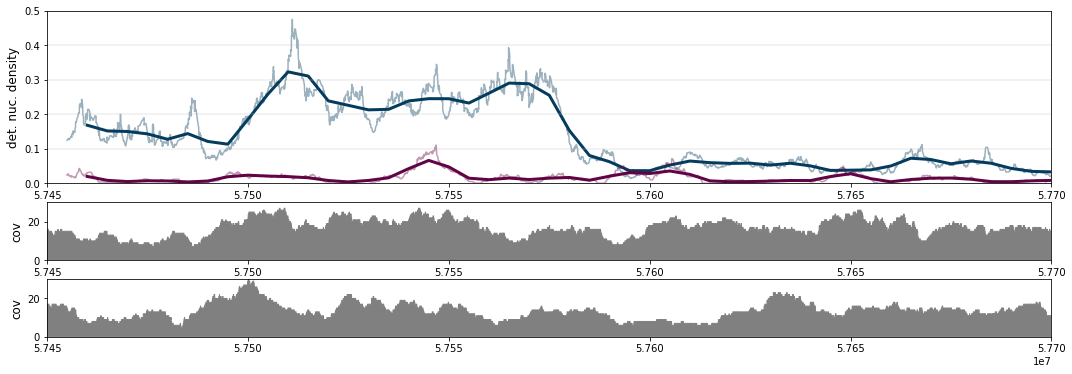

In [107]:
x = np.arange(windowstart,windowend+1)

for j in ['A']:
    fig,ax = plt.subplots(3,1, figsize = (18,6), gridspec_kw={'height_ratios': [3,1,1]})
        
    for i in [18,19]:
        if i == 18:
            colorpal = '#053C5E'
        elif i ==19:
            colorpal = '#610345'
        a = 0
        for l in [0.1,0.2,0.3,0.4]:
            ax[a].axhline(l,0,1, color = 'lightgrey', linestyle = '-',alpha = 0.2)
        
        
        ax[a].plot(x,(np.sum(nuc_call_prob_5k[i], axis = 0)/total_coverage[i][j]),color = colorpal, alpha = 0.4)
        #ax[a].plot(x,np.mean(nuc_call_prob_5k[i], axis = 0)/total_coverage[i][j]*np.shape(read_coverage[i][j])[0],color = 'yellow', alpha = 0.5)
        mean_CDR = []
        std_CDR = []
        for k in np.arange(0,250000+1,5000):
            mean_CDR.append(np.mean((np.sum(nuc_call_prob_5k[i], axis = 0)/total_coverage[i][j])[k-5000:k+5000]))
            #std_CDR.append(np.std((np.sum(nuc_call_prob_5k[i], axis = 0)/total_coverage[i][j])[k-5000:k+5000]))
        #ax[a].errorbar(np.arange(windowstart,windowend+1-50000,5000),mean_CDR, yerr = std_CDR, color = colorpal, linestyle = '-', alpha = 1)
        ax[a].plot(np.arange(windowstart,windowend+1-50000,5000), mean_CDR,color = colorpal, linestyle = '-', alpha = 1, linewidth = 3)
        
        #ax[a].set_title(Barcode_name[i], loc='left', pad=1, fontsize = 12)
        #if j == 'A': 
        ax[a].set_ylim(0,0.5)
        ax[a].set_ylabel('det. nuc. density', fontsize = 12)
        #elif j == 'C':
         #   ax[a].set_ylim(0,0.03)
        ax[a].set_xlim(window[0],window[1]-50000)
    for i in [18,19]:
        a += 1
        #ax[a].plot(x,total_coverage[i][j], 'grey')
        ax[a].fill_between(x,total_coverage[i]['A'], color = 'grey')
        #ax[a].set_title(Barcode_name[i] + ' coverage', loc='left', pad=1, fontsize = 12)
        #ax[a].axhline(5, color = 'r', linestyle = '--', alpha=0.5, linewidth = 1)
        ax[a].set_ylim(0,30)
        ax[a].set_xlim(window[0],window[1]-50000)
        ax[a].set_ylabel('cov', fontsize = 12)
fig.savefig(outfolder + Chromosome_Region + 'CA_IgG' + '_' + 'A' + '_' + str(window[0]) + '_' + str(window[1]) + 'NucCall_frac_basedonFDR.png', dpi=300, bbox_inches='tight')
plt.show()